In [2]:
from bs4 import BeautifulSoup
import requests
import re
from selenium import webdriver

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report,precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import shap

from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB
import xgboost


In [652]:
base_dat = pd.read_pickle("./FINAL_data.pkl")

In [653]:
base_dat.shape

(39078, 106)

In [654]:
# somewhere along the collection we got a few duplicate documents. We should remove them.
base_dat = base_dat.drop_duplicates(subset=['CIK','Filings','Filing Date'])

We have a bunch of leftover columns we can remove either because we cant use them or they no longer serve a purpose.

In [655]:
base_dat['Name'] = base_dat['Name'].combine_first(base_dat['debtorname'])
base_dat['total stockholders equity']= base_dat['total stockholders’ equity']+base_dat['total stockholders equity']

base_dat.drop(['debtorname','Exchange', 'SIC', 'Business', 'Incorporated',
       'IRS', '1','level_0', 'index', 'Unnamed: 0', 'industry',
       'industrygroup','disposition', '363sale', 'duration', 'incstate',
       'districtfiled', 'cityfiled', 'forumshopping', 'filingparty',
       'plantype', 'employees', 'businesssurvival', 'refiled',
       'headquarterscity', 'datedisposed', 'assetsize', 'employeesize',
       'annualsales', 'assetsmillions', 'debtorsattorney',
       'matches', 'EDGAR_name', 'Unnamed: 29','Format' ], axis='columns', inplace=True)

I dont want to keep fillings that were collected after a company has filed for bankruptcy in out example. Perhaps though another question we can answer with the data is whether a company will survive bankruptcy.

In [656]:
base_dat['d_to_bankruptcy'] = base_dat['d_to_bankruptcy'].fillna(0)

In [657]:
mask = (base_dat['d_to_bankruptcy']>=0)

# setting NAs (non bankrupt companies) to 0 days. Bankrupt companies that happen to have a filing on the same day are 
# already labeled in their bankruptcy 6 months column.

base_dat = base_dat[mask]

In [658]:
base_dat['banruptcy_6_mo'] = np.where((base_dat['d_to_bankruptcy']<=365) & (~base_dat['chapteratfiling'].isna()),1,0)

In [659]:
base_dat = base_dat.reset_index() 

In [660]:
base_dat['banruptcy_6_mo'].value_counts()

0    36977
1      643
Name: banruptcy_6_mo, dtype: int64

Make a Holdout set in 2020, ideally our model will work on companies in the future.

In [3]:
#holdout set 2020 pd.
mask = (pd.DatetimeIndex(base_dat['Filing Date']).year==2020)
holdout=base_dat[mask]

#keep the rest of the set
base_dat = base_dat[~mask]

NameError: name 'base_dat' is not defined

In [6]:
base_dat['banruptcy_6_mo'].value_counts()


0    33646
1      580
Name: banruptcy_6_mo, dtype: int64

In [7]:
holdout['banruptcy_6_mo'].value_counts()

0    3331
1      63
Name: banruptcy_6_mo, dtype: int64

We can already see some issues where numbers don't seem to be in thousands when they should be.

In [661]:
base_dat['cash and cash equivalents'].describe().apply(lambda x: format(x, 'f'))

count           31633.000000
mean         18197616.463184
std        1183096016.022964
min                 0.000000
25%              1047.000000
50%             28998.000000
75%            164074.000000
max      162543000000.000000
Name: cash and cash equivalents, dtype: object

In [673]:
X_cols=['current assets', 'cash and cash equivalents',
       'accounts receivable net', 'prepaid expenses', 'other current assets',
       'total current assets', 'property and equipment net', 'goodwill',
       'other assets', 'total assets', 'current liabilities',
       'accounts payable', 'accrued expenses',
       'current maturities of longterm debt', 'total current liabilities',
       'other longterm liabilities','accumulated deficit', 'accumulated other comprehensive loss',
       'inventories', 'restricted cash',
       'prepaid expenses and other current assets', 'deferred income taxes',
       'other noncurrent liabilities', 'total liabilities',
       'retained earnings', 'total stockholders equity',
       'total liabilities and stockholders equity', 'preferred stock',
       'current portion of longterm debt', 'other liabilities',
       'additional paidin capital', 'total stockholders’ equity',
       'total liabilities and stockholders’ equity', 'longterm debt',
       'accumulated other comprehensive income', 'noncontrolling interest',
       'intangible assets net', 'accounts payable and accrued expenses',
       'assets held for sale', 'other noncurrent assets', 'common stock',
       'noncontrolling interests', 'total equity',
       'total liabilities and equity', 'property plant and equipment net',
       'other longterm assets', 'deferred revenue', 'other',
       'accrued interest','inventory', 'asset retirement obligations', 'retained deficit',
       'accounts payable and accrued liabilities', 'accrued liabilities',
       'accounts receivable', 'other current liabilities']

In [672]:
for col in X_cols:
    base_dat[col]=[(base_dat.loc[amt,col]/1000) if (base_dat.loc[amt,col]>(np.median(base_dat[base_dat.CIK==base_dat.loc[amt,'CIK']][col])*100)) else (base_dat.loc[amt,col]) for amt in range(0,len(base_dat))]

KeyError: 'debt_ratio'

In [675]:
base_dat['current assets'].describe()

count    2.735200e+04
mean     1.627457e+07
std      3.506855e+08
min     -2.041000e+03
25%      2.512025e+03
50%      1.119805e+05
75%      4.934929e+05
max      1.691300e+10
Name: current assets, dtype: float64

1653.0

In [676]:
base_dat['liquidity_ratio'] = np.nanmean(base_dat[['current assets','total current assets']],axis=1) / np.nanmean(base_dat[['current liabilities','total current liabilities']],axis=1)
base_dat['debt_to_equity'] = np.nanmean(base_dat[['current liabilities','total current liabilities']],axis=1) / base_dat['total stockholders equity']
base_dat['debt_ratio'] =   np.nanmean(base_dat[['longterm debt','current portion of longterm debt']],axis=1)  /np.nanmean(base_dat[['current assets','total current assets']],axis=1)


Mean of empty slice
divide by zero encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice


This might be easier to identify and clean when looking at change columns.

In [677]:
for col in X_cols:
    base_dat[col] = base_dat[col].fillna(base_dat.groupby('CIK')[col].transform('mean'))

In [678]:
base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)

In [679]:
base_dat.to_csv('table_cleaning.csv')

In [682]:
#make file type change columns
for col in X_cols:
    base_dat[col+'_diff']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1),base_dat[col]-base_dat[col].shift(1),0)


In [683]:
#make file type change columns
for col in X_cols:
    base_dat[col+'_cumsum']= np.where(base_dat['Filings']==base_dat['Filings'].shift(1), base_dat[col+'_diff'].shift(1),0)

base_dat = base_dat.sort_values(by=['CIK','Filings','Filing Date']).reset_index(drop=True)
for col in X_cols:
    for l in range(1,len(base_dat)):
        base_dat.loc[l,col+'_cumsum']= np.where(base_dat.loc[l,'Filings']==base_dat.loc[l-1,'Filings'], base_dat.loc[l-1,col+'_cumsum']+base_dat.loc[l,col+'_diff'],0)


In [684]:
base_dat[base_dat.CIK==1750][['Filings','current assets','current assets_diff','current assets_cumsum']]

,Filings,current assets,current assets_diff,current assets_cumsum
0,10-K,1116.900000,0.000000,0.000000
1,10-K,954.100000,-162.800000,-162.800000
2,10-K,873.100000,-81.000000,-243.800000
3,10-K,888.500000,15.400000,-228.400000
4,10-K,362.600000,-525.900000,-754.300000
5,10-K,355.400000,-7.200000,-761.500000
6,10-K,532.466667,177.066667,-584.433333
7,10-Q,1082.500000,0.000000,0.000000
8,10-Q,1126.900000,44.400000,44.400000
9,10-Q,1155.900000,29.000000,73.400000


In [687]:
base_dat.to_pickle('base_dat.pkl')

I want to make a list of column names We are allowed to use in the model. For my own sanity.

In [702]:

X_cols=['current assets', 'cash and cash equivalents',
       'accounts receivable net', 'prepaid expenses', 'other current assets',
       'total current assets', 'property and equipment net', 'goodwill',
       'other assets', 'total assets', 'current liabilities',
       'accounts payable', 'accrued expenses',
       'current maturities of longterm debt', 'total current liabilities',
       'other longterm liabilities','accumulated deficit', 'accumulated other comprehensive loss',
       'inventories', 'restricted cash',
       'prepaid expenses and other current assets', 'deferred income taxes',
       'other noncurrent liabilities', 'total liabilities',
       'retained earnings', 'total stockholders equity',
       'total liabilities and stockholders equity', 'preferred stock',
       'current portion of longterm debt', 'other liabilities',
       'additional paidin capital', 'total stockholders’ equity',
       'total liabilities and stockholders’ equity', 'longterm debt',
       'accumulated other comprehensive income', 'noncontrolling interest',
       'intangible assets net', 'accounts payable and accrued expenses',
       'assets held for sale', 'other noncurrent assets', 'common stock',
       'noncontrolling interests', 'total equity',
       'total liabilities and equity', 'property plant and equipment net',
       'other longterm assets', 'deferred revenue', 'other',
       'accrued interest','inventory', 'asset retirement obligations', 'retained deficit',
       'accounts payable and accrued liabilities', 'accrued liabilities',
       'accounts receivable', 'other current liabilities','debt_ratio','debt_to_equity','liquidity_ratio']

diff_cols = [s + '_diff' for s in X_cols]

cum_cols = [s + '_cumsum' for s in X_cols]

X=base_dat[X_cols]

y=base_dat['banruptcy_6_mo']

from sklearn.model_selection import train_test_split

# I will make a small test set here to act as the holdout data since I would like to use kfolds for the models.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)


# XGBoost

In [703]:
from sklearn.naive_bayes import GaussianNB
import xgboost

#max_delta_step: documentation mentions increasing from 1-10 may help in logistic cases with high imbalance data.
#max_depth 12, delta_step=2     
gboost= xgboost.XGBClassifier(max_depth=6,max_delta_step=6,eta=0.8)



gboost.fit(X_train, y_train)

y_preds = gboost.predict(X_test)

#print('accuracy: ',np.mean(cross_val_score(gboost, X_train, y_train, cv=5)))
#print('precision: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='precision')))
#print('recall: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='recall')))
#print('F1: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='f1')))


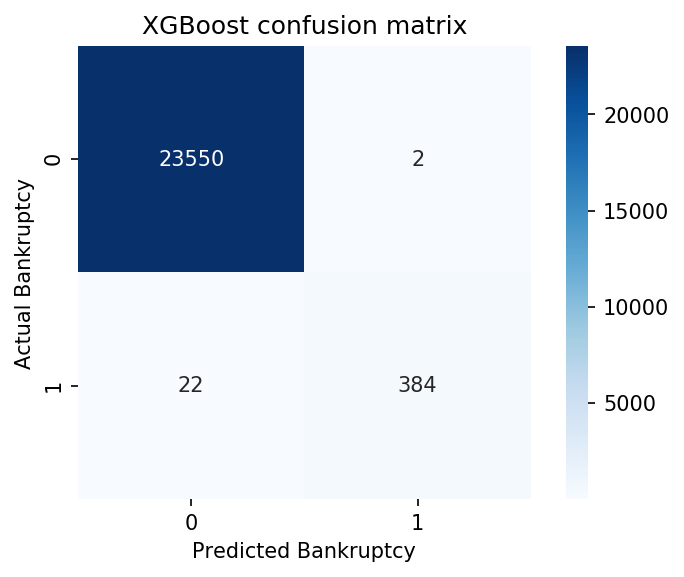

In [704]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, gboost.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

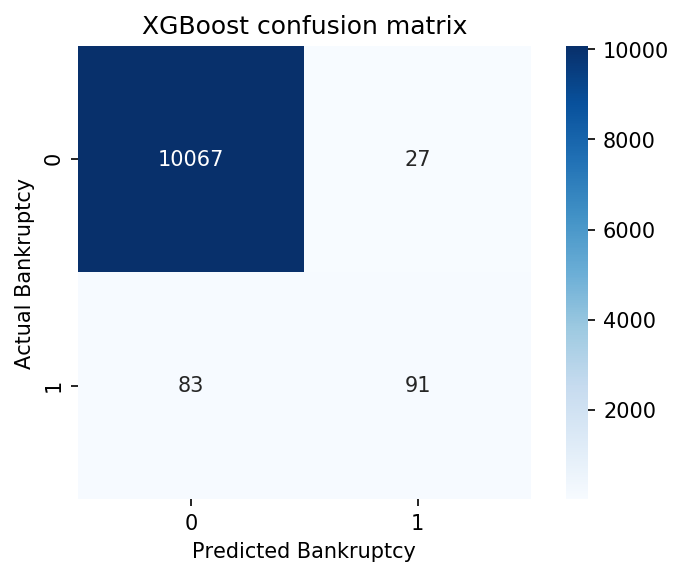

In [705]:
# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, gboost.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

Well since that did so well I might as well try the out of sample data already...

Text(0.5, 0, 'Xgboost Feature Importance')

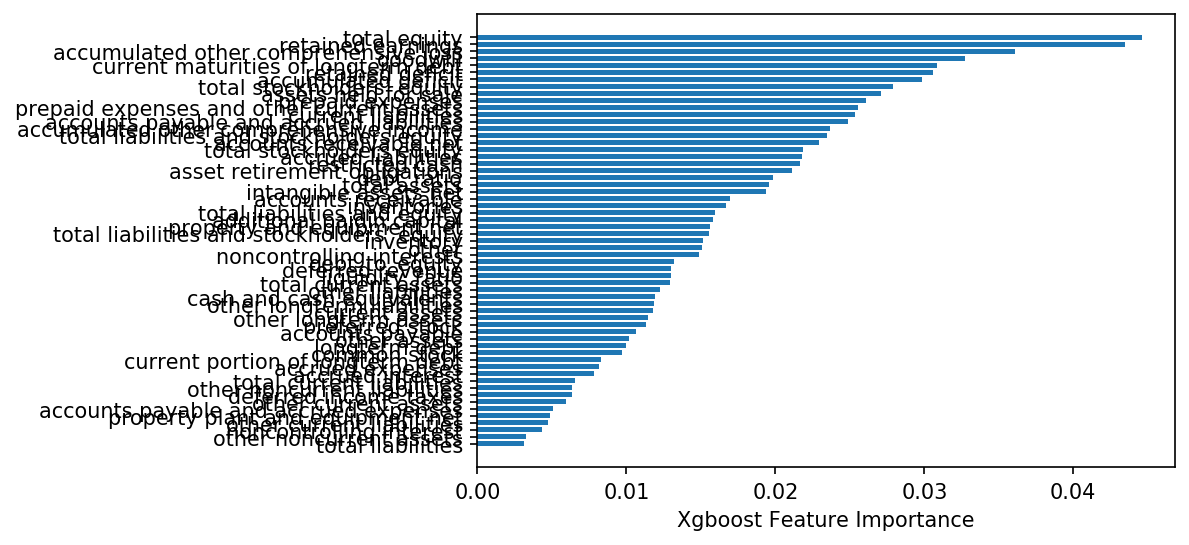

In [706]:
plt.figure(dpi=150)
sorted_idx = gboost.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], gboost.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

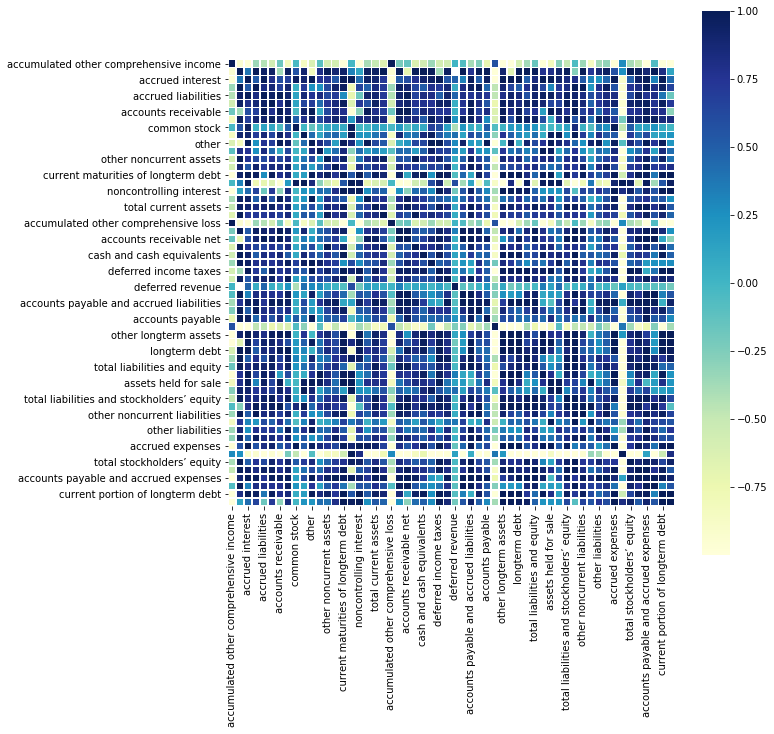

In [170]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5
                )
    plt.show();
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])

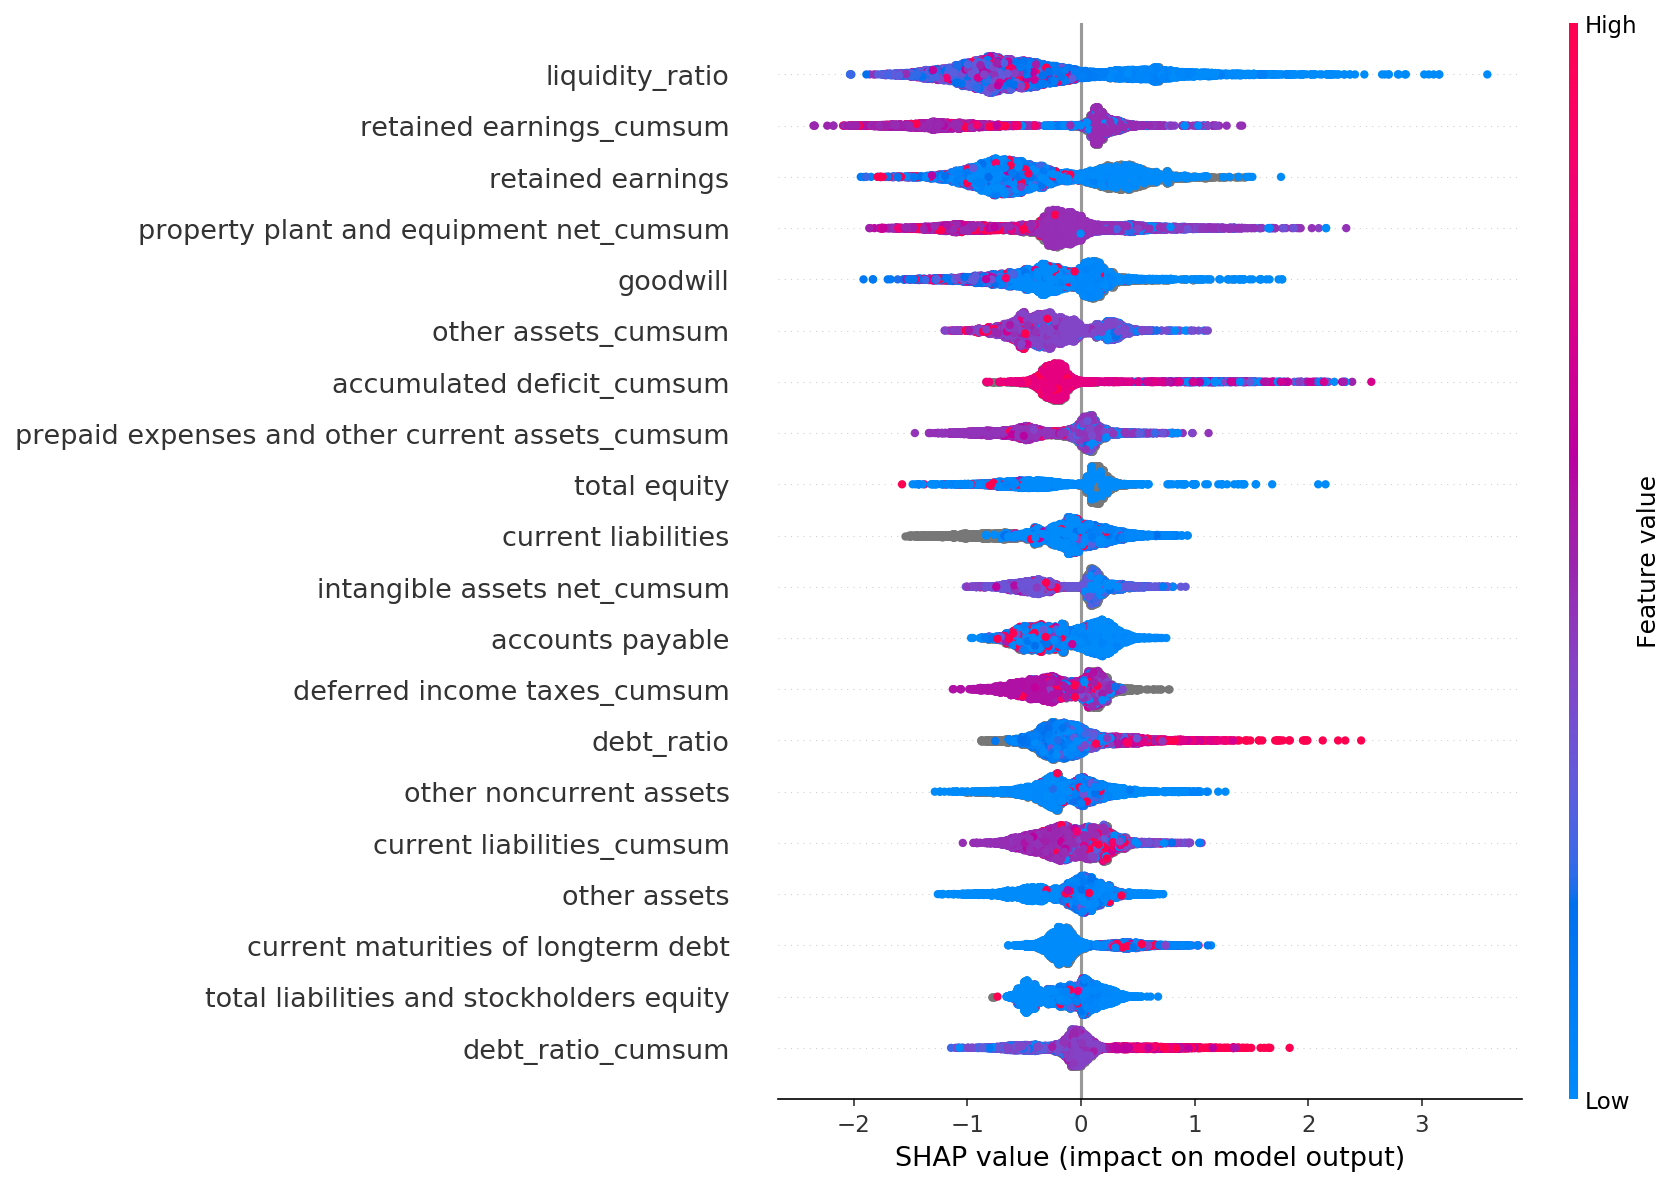

In [555]:
plt.figure(dpi=150)
explainer = shap.TreeExplainer(gboost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Adding change columns

In [8]:

X_cols=['current assets', 'cash and cash equivalents',
       'accounts receivable net', 'prepaid expenses', 'other current assets',
       'total current assets', 'property and equipment net', 'goodwill',
       'other assets', 'total assets', 'current liabilities',
       'accounts payable', 'accrued expenses',
       'current maturities of longterm debt', 'total current liabilities',
       'other longterm liabilities','accumulated deficit', 'accumulated other comprehensive loss',
       'inventories', 'restricted cash',
       'prepaid expenses and other current assets', 'deferred income taxes',
       'other noncurrent liabilities', 'total liabilities',
       'retained earnings', 'total stockholders equity',
       'total liabilities and stockholders equity', 'preferred stock',
       'current portion of longterm debt', 'other liabilities',
       'additional paidin capital', 'total stockholders’ equity',
       'total liabilities and stockholders’ equity', 'longterm debt',
       'accumulated other comprehensive income', 'noncontrolling interest',
       'intangible assets net', 'accounts payable and accrued expenses',
       'assets held for sale', 'other noncurrent assets', 'common stock',
       'noncontrolling interests', 'total equity',
       'total liabilities and equity', 'property plant and equipment net',
       'other longterm assets', 'deferred revenue', 'other',
       'accrued interest','inventory', 'asset retirement obligations', 'retained deficit',
       'accounts payable and accrued liabilities', 'accrued liabilities',
       'accounts receivable', 'other current liabilities']

diff_cols = [s + '_diff' for s in X_cols]
cum_cols = [s + '_cumsum' for s in X_cols]


X=base_dat[X_cols+diff_cols+cum_cols]

y=base_dat['banruptcy_6_mo']

from sklearn.model_selection import train_test_split

# I will make a small test set here to act as the holdout data since I would like to use kfolds for the models.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)


In [711]:
from sklearn.naive_bayes import GaussianNB
import xgboost

#max_delta_step: documentation mentions increasing from 1-10 may help in logistic cases with high imbalance data.
#max_depth 12, delta_step=2     
gboost= xgboost.XGBClassifier(max_depth=6, delta_step=2)



gboost.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='auc',verbose=False)

y_preds = gboost.predict(X_test)

#print('accuracy: ',np.mean(cross_val_score(gboost, X_train, y_train, cv=5)))
#print('precision: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='precision')))
#print('recall: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='recall')))
#print('F1: ',np.mean(cross_val_score(gboost,X_train, y_train,scoring='f1')))


[17:27:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { delta_step } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [712]:
evals_result = gboost.evals_result()

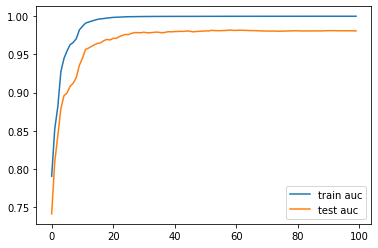

In [713]:
x_vals = range(0,len(evals_result['validation_0']['auc']))
sns.lineplot(x_vals ,evals_result['validation_0']['auc'],label='train auc')
sns.lineplot(x_vals ,evals_result['validation_1']['auc'],label='test auc')

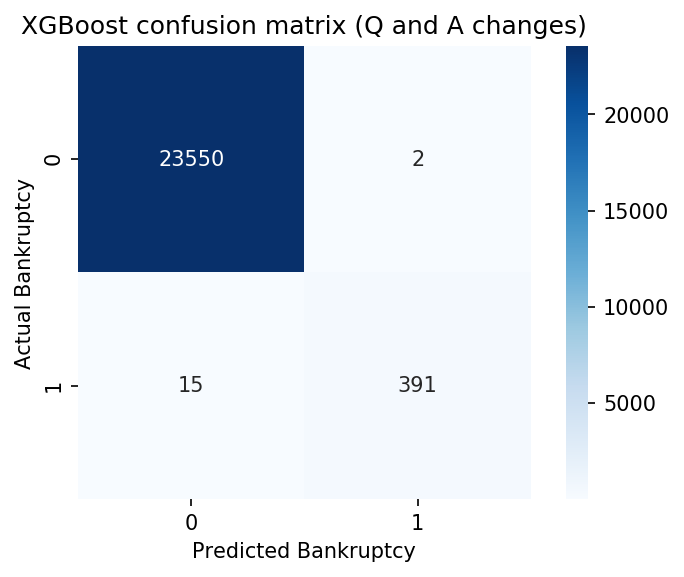

In [714]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, gboost.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (Q and A changes)');

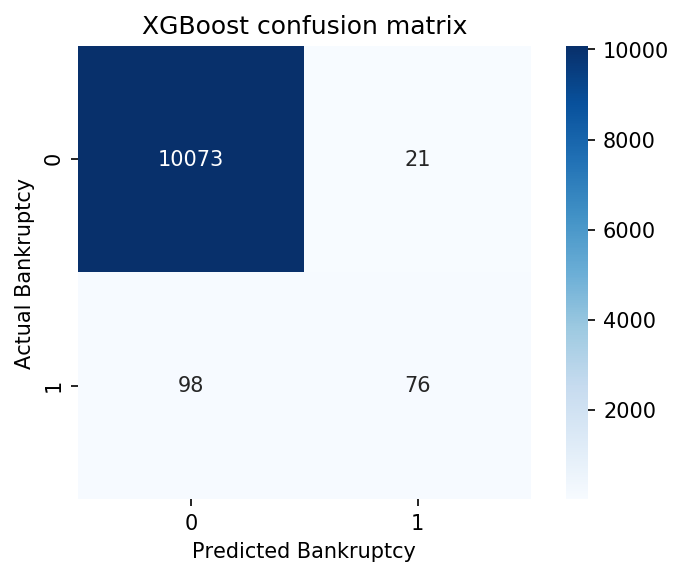

In [715]:
# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, gboost.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

Well since that did so well I might as well try the out of sample data already...

In [560]:
param_dict={'base_score': 0.4,
 'booster': 'gbtree',
 'colsample_bylevel': .8,
 'colsample_bytree': .8,
 'gamma': 0,
 'learning_rate': 0.4,
 'max_delta_step': 6,
 'max_depth': 6,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }

xgb = xgboost.XGBClassifier(**param_dict,n_jobs=2)


xgb.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='auc',verbose=False)


XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=6, max_depth=6,
              min_child_weight=2, missing=None, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

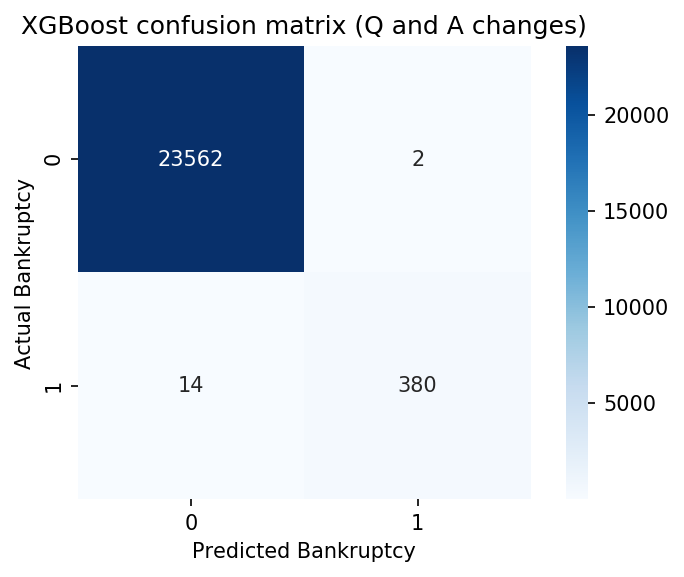

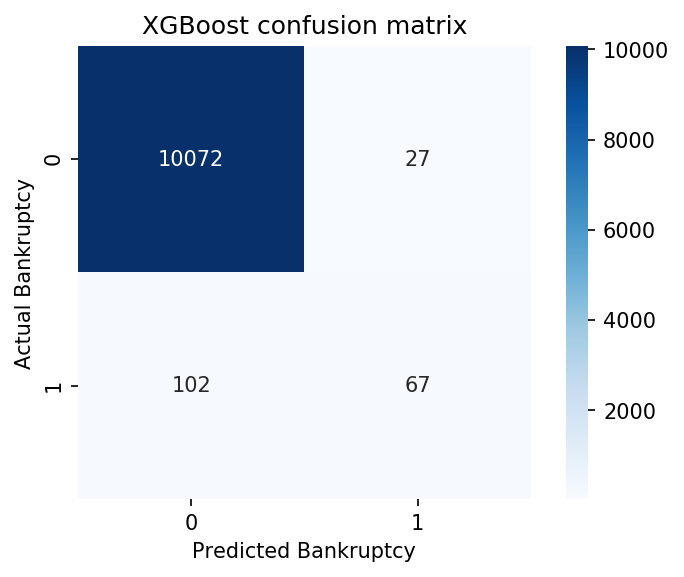

In [561]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (Q and A changes)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

Text(0.5, 0, 'Xgboost Feature Importance')

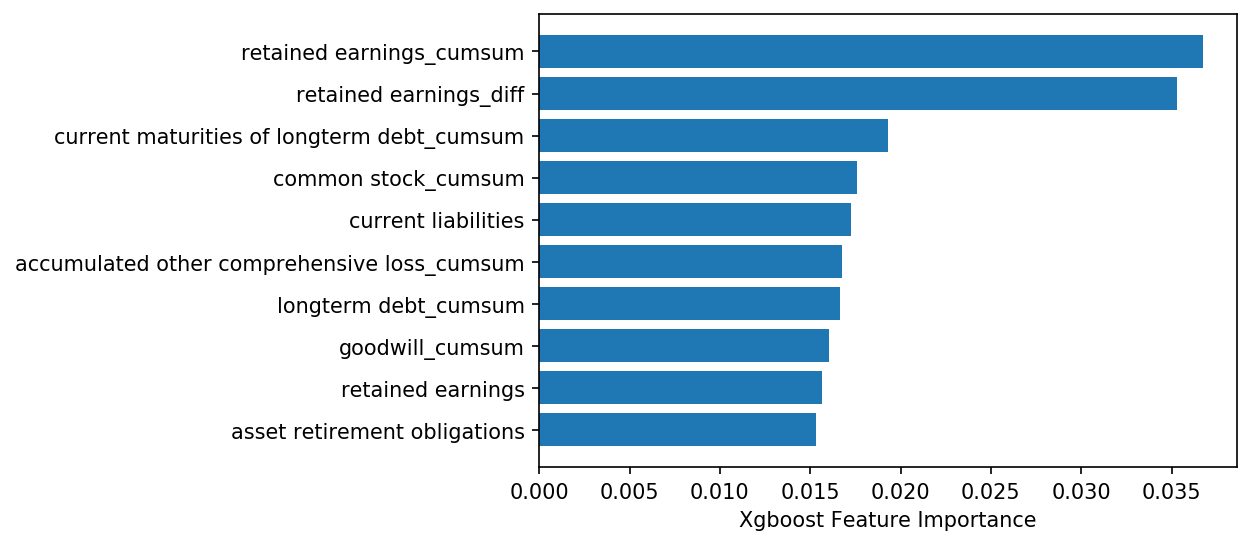

In [564]:
plt.figure(dpi=150)
sorted_idx = gboost.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx[-10:]], gboost.feature_importances_[sorted_idx[-10:]])
plt.xlabel("Xgboost Feature Importance")

In [280]:
gboost.feature_importances_

array([0.00611511, 0.00431828, 0.01173863, 0.00360527, 0.00605805,
       0.01439107, 0.00904211, 0.00680171, 0.00735368, 0.0158687 ,
       0.00880953, 0.00463936, 0.00464724, 0.00739986, 0.00516238,
       0.00961918, 0.00406054, 0.00845001, 0.01543015, 0.00701013,
       0.01848426, 0.00813792, 0.01323492, 0.00308537, 0.01427009,
       0.01878943, 0.0067976 , 0.01354058, 0.01783676, 0.00355113,
       0.00839941, 0.01298749, 0.01329493, 0.00546171, 0.00906218,
       0.00102012, 0.0124889 , 0.00303247, 0.01182172, 0.01600012,
       0.01066612, 0.00702957, 0.01284928, 0.01024816, 0.00572258,
       0.01538904, 0.00855201, 0.00388472, 0.00497244, 0.00703356,
       0.02869866, 0.02644188, 0.0068171 , 0.01432555, 0.01605951,
       0.00042196, 0.02103878, 0.0042564 , 0.01912555, 0.00382126,
       0.00324112, 0.00500022, 0.0124629 , 0.00839332, 0.01536332,
       0.00916677, 0.00357321, 0.00352076, 0.00359868, 0.00575021,
       0.00746216, 0.00760786, 0.00965381, 0.00998774, 0.00551

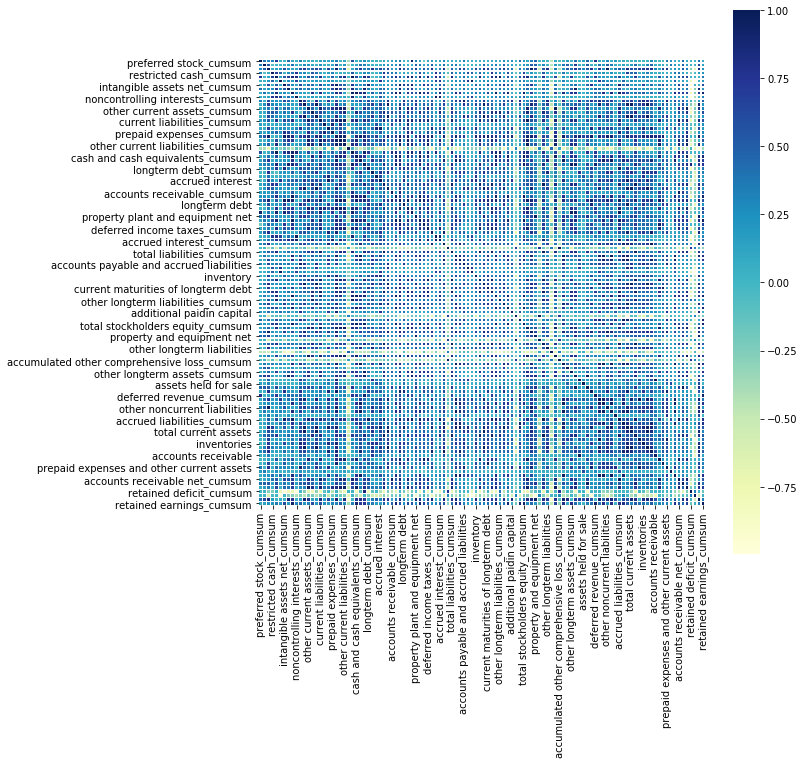

In [281]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5
                )
    plt.show();
    
correlation_heatmap(X_train[X_train.columns[sorted_idx]])

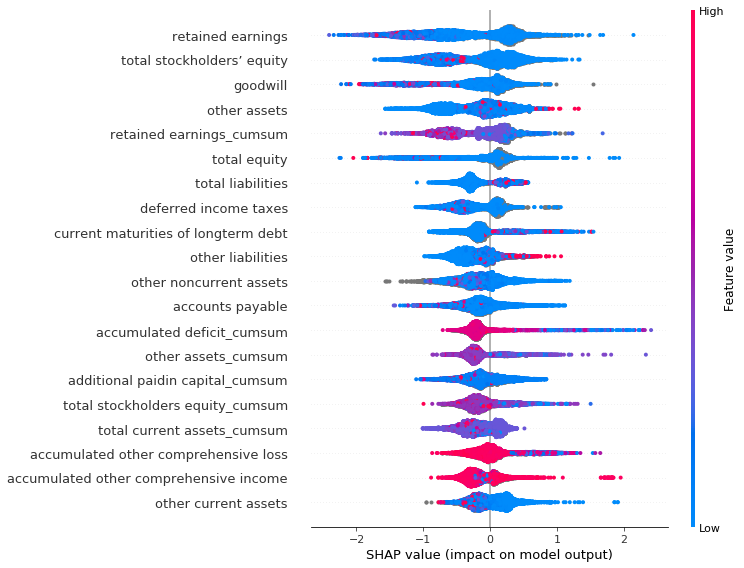

In [282]:
explainer = shap.TreeExplainer(gboost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

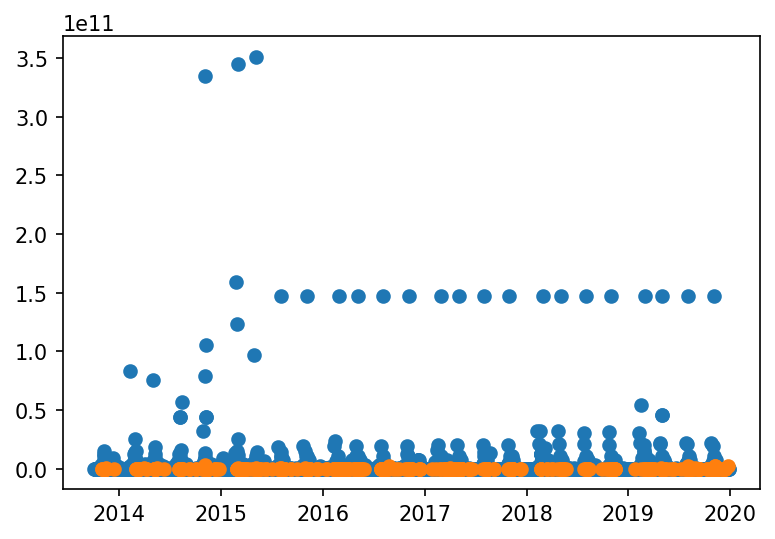

In [283]:
plt.figure(dpi=150)
plt.plot_date(x='Filing Date',y='total assets', data=base_dat[base_dat.banruptcy_6_mo==0])
plt.plot_date(x='Filing Date',y='total assets', data=base_dat[base_dat.banruptcy_6_mo==1])

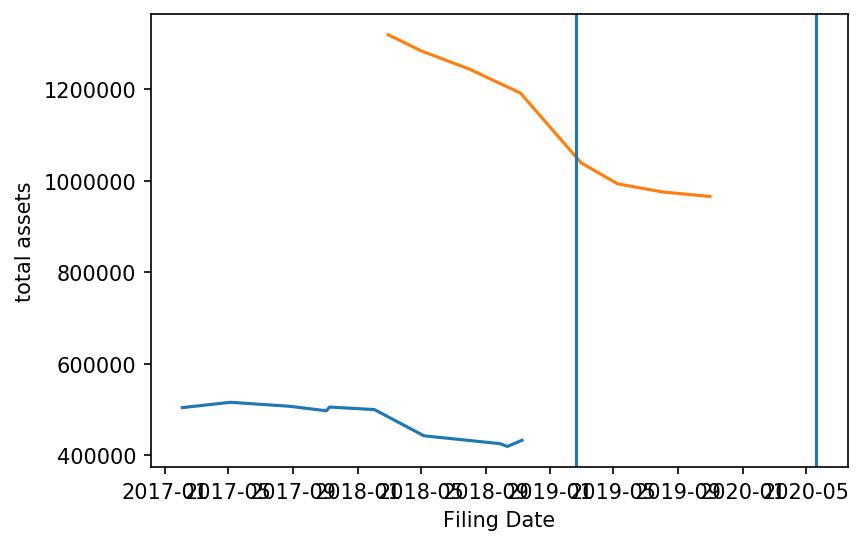

In [284]:
bank = base_dat[base_dat.banruptcy_6_mo==1]['CIK'].unique()
bankrupt_d =base_dat[ base_dat['CIK'].isin(bank)]
plt.figure(dpi=150)
sns.lineplot(x='Filing Date',y='total assets', data=bankrupt_d[bankrupt_d.CIK==2034])
sns.lineplot(x='Filing Date',y='total assets', data=bankrupt_d[bankrupt_d.CIK==3116])
plt.axvline(bankrupt_d[bankrupt_d.CIK==2034]['datefiled'].values[0])
plt.axvline(bankrupt_d[bankrupt_d.CIK==3116]['datefiled'].values[0])



numpy.datetime64('2019-02-19T00:00:00.000000000')

In [186]:
url = 'https://lopucki.law.ucla.edu/spreadsheet.htm'
response = requests.get(url)
page = response.text
info = BeautifulSoup(page,"lxml")
table=info.find('table')
table= table.find_all('td')

bankruptcy_dat = {}
column_labs=[]
for labs in table[0].find_all('th'):
    column_labs.append(labs.text)

bankruptcy_dat = {}
for rows in table[0].find_all('tr')[1:]:
    dat = rows.text.split('\n')[1:26]
    bankruptcy_dat[dat[0]]=dict(zip(column_labs, dat))

  


In [187]:
df = pd.DataFrame.from_dict(bankruptcy_dat, orient='index')
# clean columns
df.columns = df.columns.map(lambda x: re.sub(r'\W+', '', x).lower())

In [222]:
len(df['debtorname'].unique())

1202

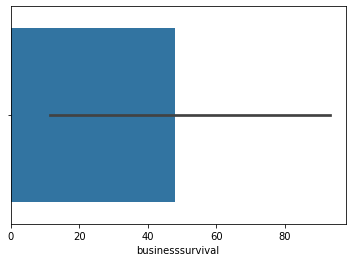

In [207]:
mask = (pd.DatetimeIndex(df['datefiled']).year>=2015)
quick=df[mask]

sns.barplot(quick['businesssurvival'].value_counts())

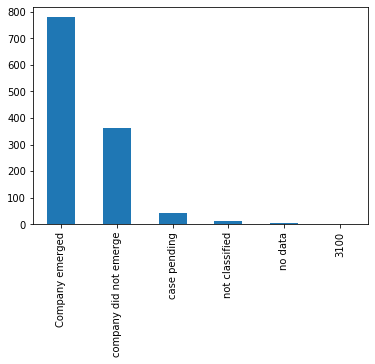

In [212]:
pd.value_counts(df['businesssurvival']).plot.bar()

# Trying to use oversampling and undersampling.

### oversampling

In [716]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [718]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_resampled, y_resampled = sm.fit_sample(X_train, y_train) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [717]:
param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 15,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()


xgb.fit(X_resampled,y_resampled,eval_set=[(X_resampled, y_resampled), (X_test, y_test)],eval_metric='auc',verbose=False)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

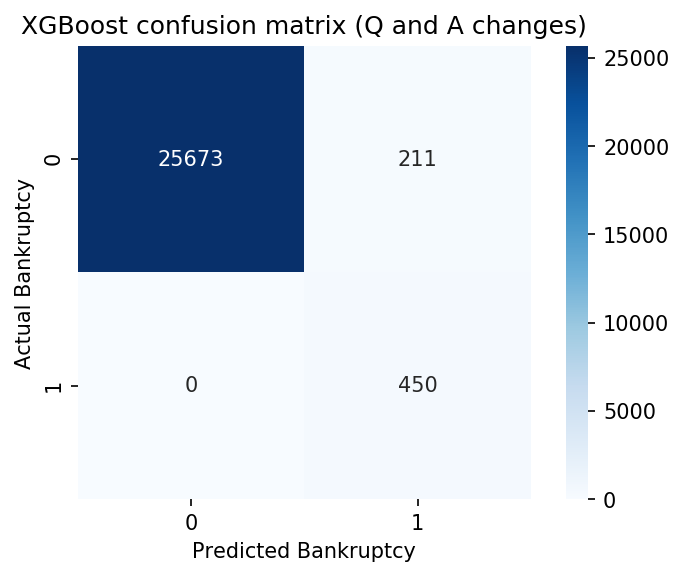

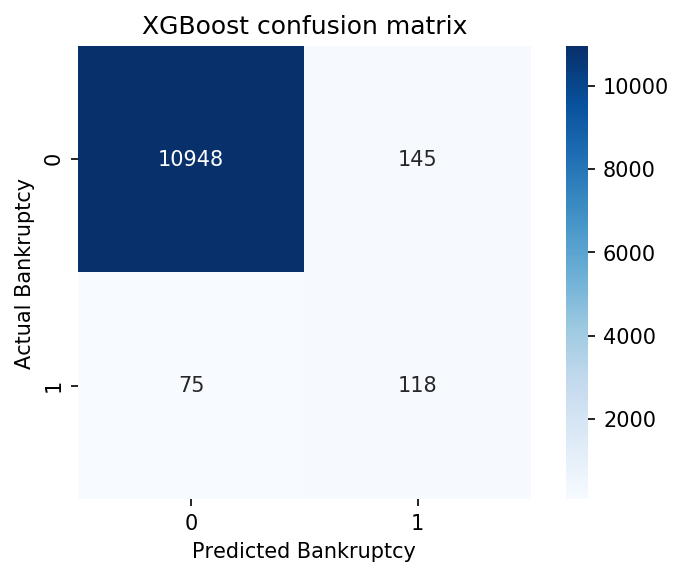

In [698]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (Q and A changes)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

In [132]:
base_dat[base_dat.CIK==1735707]

,level_0,index,CIK,Ticker,Name,Filings,Description,Filing Date,File/Film Number,links,...,deferred revenue_diff,other_diff,accrued interest_diff,inventory_diff,asset retirement obligations_diff,retained deficit_diff,accounts payable and accrued liabilities_diff,accrued liabilities_diff,accounts receivable_diff,other current liabilities_diff
34222,37228,38644,1735707,NaN,Garrett Motion Inc.,10-Q,Quarterly report [Sections 13 or 15(d)]Acc-no:...,2018-11-06,001-38636181163827,/Archives/edgar/data/1735707/00015645901802750...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-189616.0


# try imputing Nans

Above, I have already tried imputing NaNs with means basked on the company in question when available, however there are still quite a lot of values missing.

In [150]:
base_dat.shape

(34226, 72)

In [153]:
base_dat[X_cols].isna().sum()

current assets                                 7785
cash and cash equivalents                      2473
accounts receivable net                       20276
prepaid expenses                              26989
other current assets                           2934
total current assets                            351
property and equipment net                    10486
goodwill                                       9616
other assets                                    400
total assets                                    303
current liabilities                            7586
accounts payable                               9930
accrued expenses                              24164
current maturities of longterm debt           20061
total current liabilities                       476
other longterm liabilities                     8995
accumulated deficit                           22962
accumulated other comprehensive loss           4032
inventories                                   16438
restricted c

In [191]:
test = base_dat[X_cols+['banruptcy_6_mo']].dropna(thresh=base_dat[X_cols].shape[0]*0.75,how='all',axis=1)

In [192]:
test.columns

Index(['current assets', 'cash and cash equivalents', 'other current assets',
       'total current assets', 'other assets', 'total assets',
       'current liabilities', 'total current liabilities',
       'accumulated other comprehensive loss', 'other noncurrent liabilities',
       'total liabilities', 'total stockholders equity',
       'total liabilities and stockholders equity', 'other liabilities',
       'total stockholders’ equity',
       'total liabilities and stockholders’ equity',
       'accumulated other comprehensive income', 'other noncurrent assets',
       'total liabilities and equity', 'other current liabilities',
       'banruptcy_6_mo'],
      dtype='object')

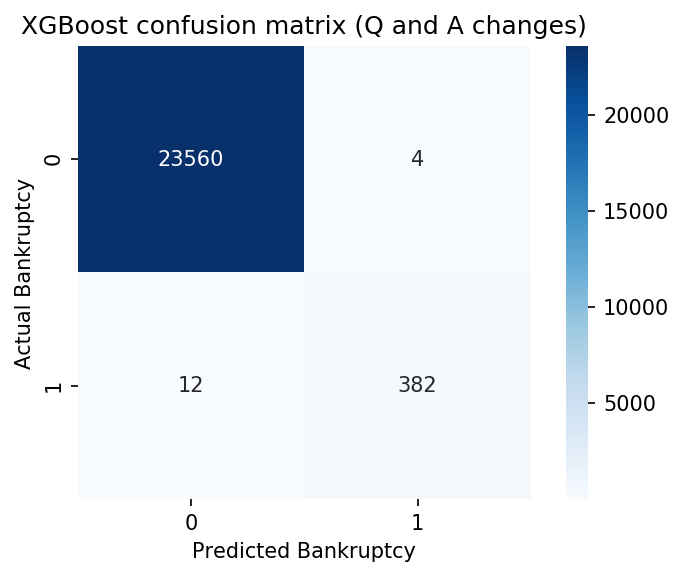

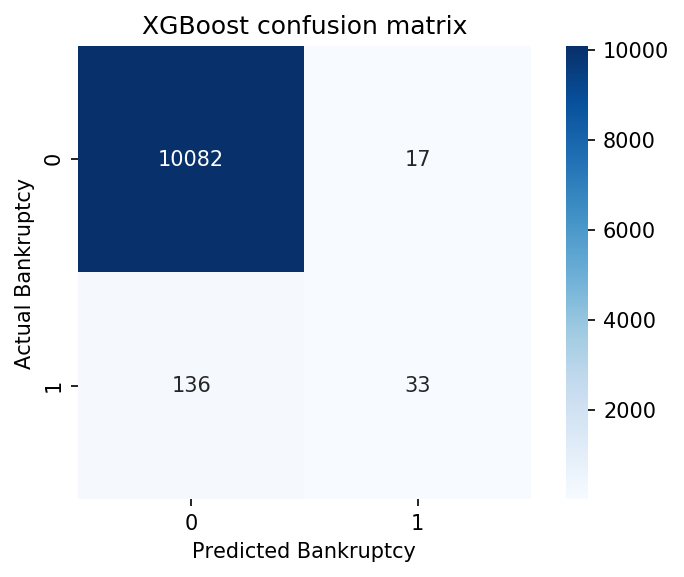

In [186]:
diff_cols = [s + '_diff' for s in test.columns]

X=base_dat[test.columns.to_list()+diff_cols]

y=base_dat['banruptcy_6_mo']


from sklearn.model_selection import train_test_split

# I will make a small test set here to act as the holdout data since I would like to use kfolds for the models.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train)

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (Q and A changes)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

Text(0.5, 0, 'Xgboost Feature Importance')

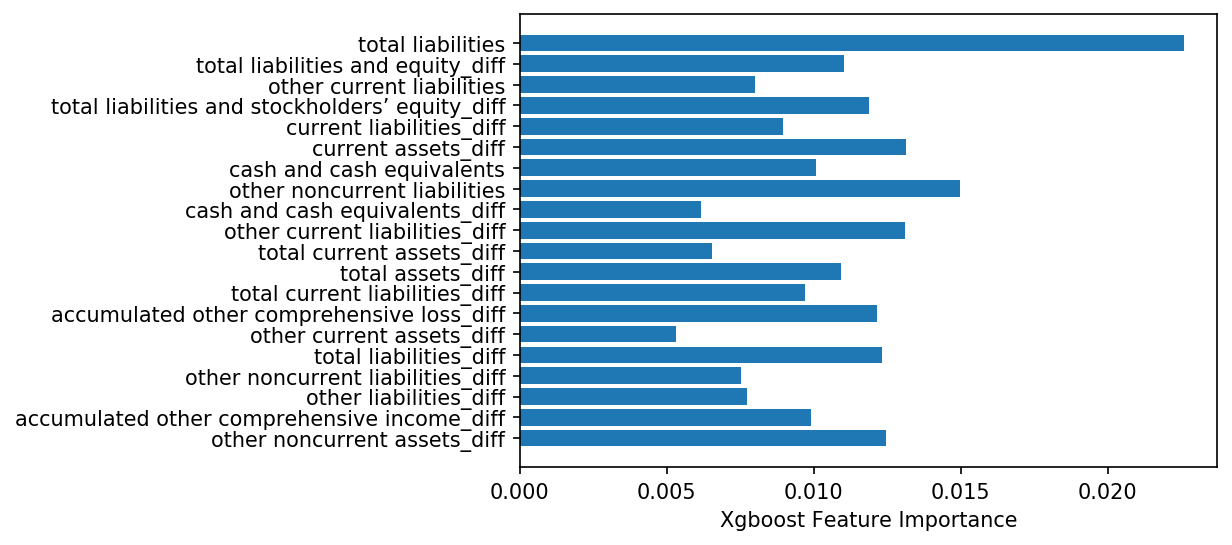

In [188]:
plt.figure(dpi=150)
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx[0:20]], gboost.feature_importances_[sorted_idx[0:20]])
plt.xlabel("Xgboost Feature Importance")

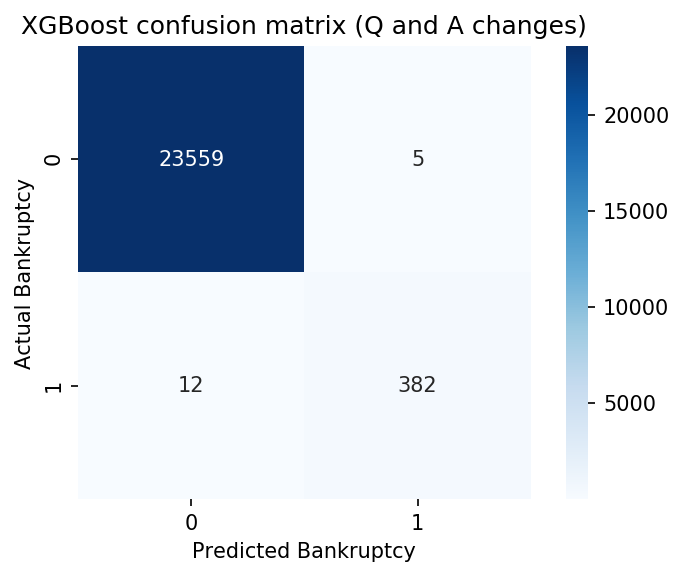

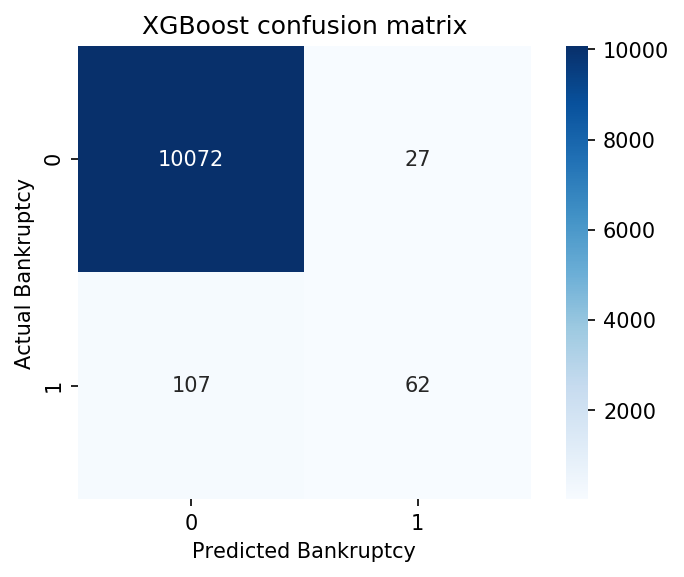

In [288]:
## Fill NaNs with 0
#diff_cols = [s + '_diff' for s in test.columns]

X_0s= X.fillna(0)

y=base_dat['banruptcy_6_mo']


from sklearn.model_selection import train_test_split

# I will make a small test set here to act as the holdout data since I would like to use kfolds for the models.
X_train, X_test, y_train, y_test = train_test_split(X_0s, y, test_size=0.3, random_state=2, stratify=y)

xgb = xgboost.XGBClassifier()


xgb.fit(X_train,y_train)

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix (Q and A changes)');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

ROC AUC score =  0.7793082213893109


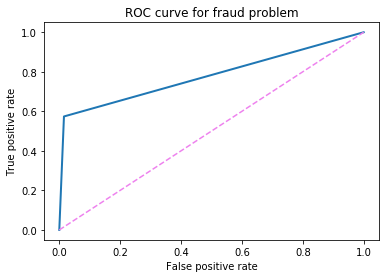

In [289]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

knn = KNeighborsClassifier(n_neighbors=1)
knn = knn.fit(X_resampled, y_resampled)

train_preds = knn.score(X_resampled, y_resampled)
test_preds = knn.score(X_test, y_test)


fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

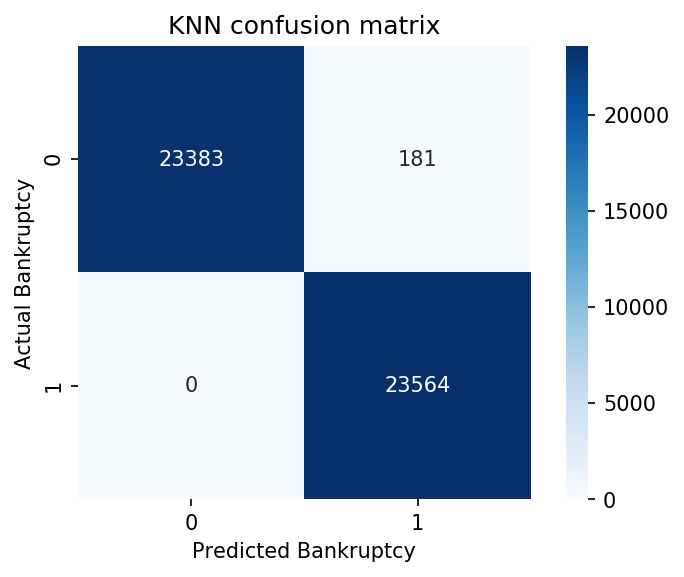

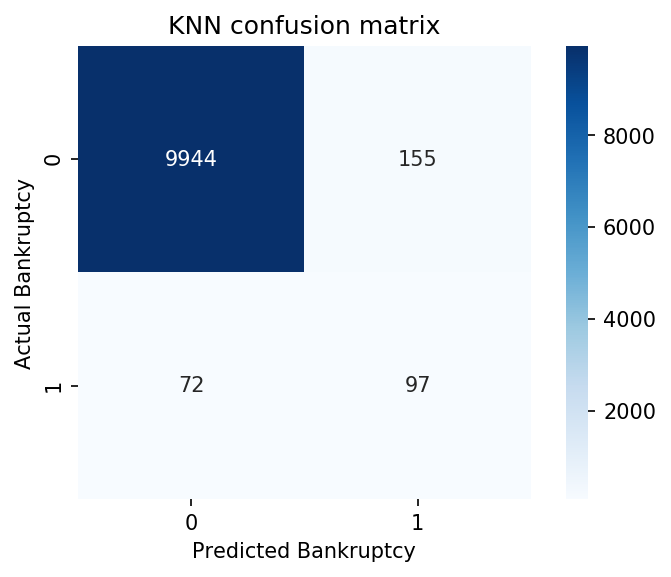

In [290]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_resampled, knn.predict(X_resampled))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('KNN confusion matrix');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('KNN confusion matrix');

In [291]:
X_test_check = X_test
X_test_check['predict']= knn.predict(X_test)
#X_test_check['banruptcy_6_mo']= y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [292]:
X_test_check['banruptcy_6_mo']= y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [293]:
error_mask = (X_test_check.predict==0) & (X_test_check.banruptcy_6_mo==1)
X_test_check[error_mask]

,current assets,cash and cash equivalents,accounts receivable net,prepaid expenses,other current assets,total current assets,property and equipment net,goodwill,other assets,total assets,...,accrued interest_cumsum,inventory_cumsum,asset retirement obligations_cumsum,retained deficit_cumsum,accounts payable and accrued liabilities_cumsum,accrued liabilities_cumsum,accounts receivable_cumsum,other current liabilities_cumsum,predict,banruptcy_6_mo
33620,102924.500000,92695.0,41641.0,0.0,7.338533e+04,1.757470e+05,82048.0,45111.0,1.506203e+05,3.157500e+05,...,-81.0,-7746.0,0.000000,-58805.0,0.0,0.0,0.0,-1.170667e+04,0,1
29295,82913.000000,53027.0,1780.0,2425.0,4.245200e+04,2.503197e+05,244314.0,0.0,1.672815e+05,1.391587e+05,...,12723.0,0.0,0.000000,0.0,0.0,0.0,-16643.0,2.846270e+05,0,1
26473,836752.000000,602024.0,0.0,0.0,8.367520e+05,2.664416e+06,22759.0,328264.0,3.439912e+06,2.572192e+06,...,0.0,0.0,205004.000000,2010.0,0.0,5405.0,0.0,1.605650e+04,0,1
31003,1172.900000,262.1,0.0,0.0,6.198500e+02,1.884367e+03,795.3,313.5,1.778900e+03,1.576900e+03,...,0.0,-157.0,0.000000,0.0,0.0,0.0,0.0,-2.550000e+01,0,1
8376,29892.000000,6058.0,0.0,9910.0,2.989200e+04,2.183565e+05,0.0,828.0,2.110257e+05,2.305457e+05,...,0.0,0.0,0.000000,0.0,0.0,0.0,-709.0,1.809380e+05,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34180,36782.000000,4684.0,13405.0,0.0,1.935900e+04,3.085560e+05,368069.0,0.0,4.056575e+05,4.212530e+05,...,0.0,0.0,-177.333333,0.0,0.0,3681.0,22925.0,-7.153800e+04,0,1
32059,111603.666667,151037.0,0.0,0.0,1.116037e+05,1.275740e+05,734485.0,0.0,2.576350e+04,1.710010e+05,...,0.0,0.0,-2645.000000,-589317.0,0.0,-52762.0,0.0,-5.759050e+04,0,1
33619,94861.000000,27911.0,41641.0,0.0,6.824767e+04,1.991162e+05,126495.5,45961.0,1.798443e+05,3.470715e+05,...,1.0,4227.0,0.000000,-31150.0,0.0,0.0,0.0,-4.052667e+03,0,1
32229,489691.000000,125922.0,220000.0,309.0,2.450000e+05,2.797772e+05,13603.0,0.0,2.518645e+05,3.311400e+05,...,0.0,-108972.0,0.000000,0.0,0.0,0.0,111915.0,7.276450e+04,0,1


In [260]:
error_mask = (X_test_check.predict==1) & (X_test_check.banruptcy_6_mo==1)
X_test_check[error_mask]

,current assets,cash and cash equivalents,other current assets,total current assets,other assets,total assets,current liabilities,total current liabilities,accumulated other comprehensive loss,other noncurrent liabilities,...,total liabilities and stockholders equity_diff,other liabilities_diff,total stockholders’ equity_diff,total liabilities and stockholders’ equity_diff,accumulated other comprehensive income_diff,other noncurrent assets_diff,total liabilities and equity_diff,other current liabilities_diff,predict,banruptcy_6_mo
51,502627.0,100874.0,2.551230e+05,5.240563e+05,387321.5,4.257567e+05,3.025180e+05,4.871285e+05,-885.0,3.025180e+05,...,-273766.0,20865.000000,-312387.0,-273766.0,4227.0,28467.000000,-117572.5,79713.0,1,1
24022,70875.0,23931.0,4.362300e+04,1.108588e+06,678260.0,4.757983e+05,1.923974e+06,1.939332e+06,7140.0,6.580887e+05,...,-374355.0,17938.333333,-420868.0,-374355.0,-9286.0,3951.000000,46513.0,613127.0,1,1
12744,649373.0,18986.0,3.307975e+05,1.204584e+06,1083447.5,9.387560e+05,4.049190e+05,1.014652e+06,-500.0,4.049190e+05,...,-9938.0,-1692.000000,0.0,-9938.0,-528.0,18585.000000,-6663.0,3472.0,1,1
13011,2864.3,2146.6,2.864300e+03,6.656100e+03,15207.5,9.035900e+03,1.896500e+03,1.208245e+04,-40.4,1.896500e+03,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,1
25773,861707150.5,19682724.0,5.749364e+08,1.159762e+09,862404632.5,5.955802e+08,1.192219e+09,1.192219e+09,-2101646.0,5.992153e+08,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25480,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,1
25142,940933.0,476295.0,9.409330e+05,3.248806e+06,10169447.0,5.864999e+06,7.023205e+05,2.838567e+06,-287697.0,7.023205e+05,...,-642767.5,-377894.500000,-262157.0,-1023378.0,-214302.0,-226597.666667,-892299.5,-88110.0,1,1
15994,368297.0,6306.0,1.522397e+05,4.979207e+05,445907.5,6.191570e+05,1.529920e+05,1.529920e+05,-93622.0,1.629607e+05,...,615.0,-14548.500000,0.0,615.0,5910.0,19442.000000,0.0,-4368.0,1,1
18907,0.0,135220.5,1.983100e+04,1.771555e+06,895693.0,8.956930e+05,0.000000e+00,1.597506e+06,933.0,0.000000e+00,...,-1178510.5,-450377.000000,-524416.0,-1832605.0,120.0,0.000000,-1141491.0,0.0,1,1


### Logistic Regression

ROC AUC score =  0.5627541774304211


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


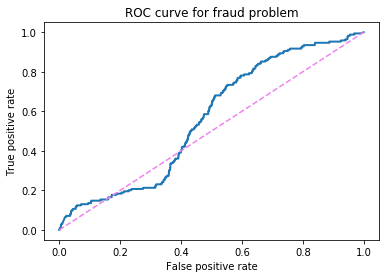

In [211]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='none')

lr.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

### SVC

ROC AUC score =  0.5411722761231852


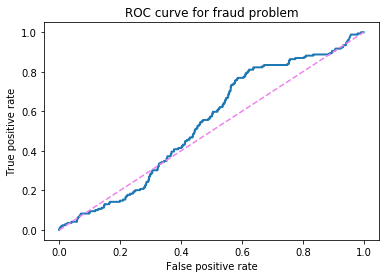

In [213]:
# Redo the model for probability =- True
from sklearn.svm import SVC

svc_m = SVC(probability=True)

svc_m.fit(X_train, y_train)

y_predict = svc_m.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, svc_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, svc_m.predict_proba(X_test)[:,1]))

### GaussianNB Model

ROC AUC score =  0.5061389287474124


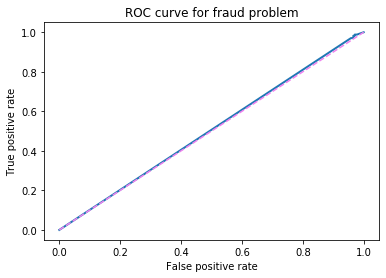

In [214]:
from sklearn.naive_bayes import GaussianNB

gb_m = GaussianNB()

gb_m.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, gb_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, gb_m.predict_proba(X_test)[:,1]))

### Decision Tree

ROC AUC score =  0.644227473456567


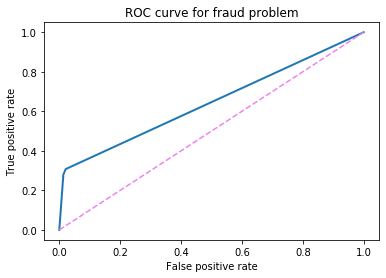

In [216]:
from sklearn.tree import DecisionTreeClassifier

tree_m = DecisionTreeClassifier()

tree_m.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, tree_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, tree_m.predict_proba(X_test)[:,1]))

### Random Forest

ROC AUC score =  0.9828654896407224


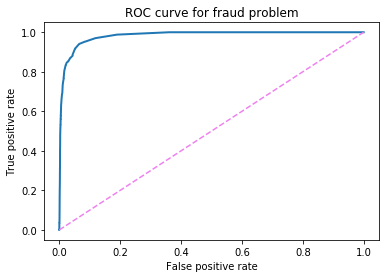

In [303]:
from sklearn.ensemble import RandomForestClassifier

RF_m = RandomForestClassifier()

RF_m.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, RF_m.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, RF_m.predict_proba(X_test)[:,1]))

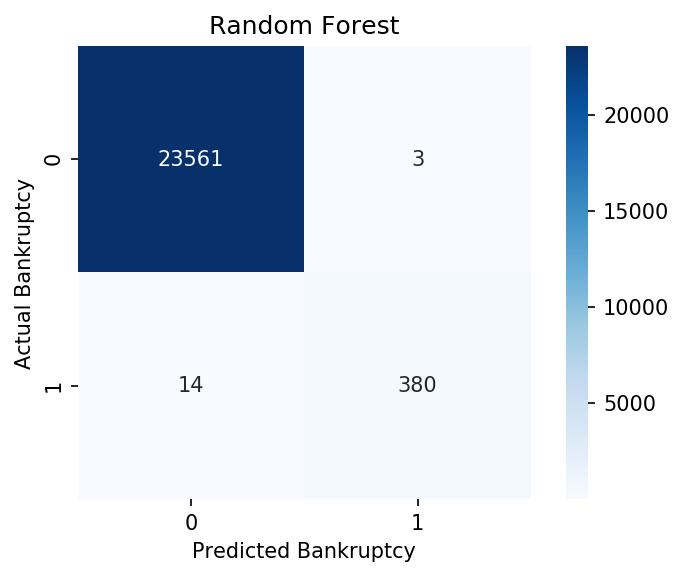

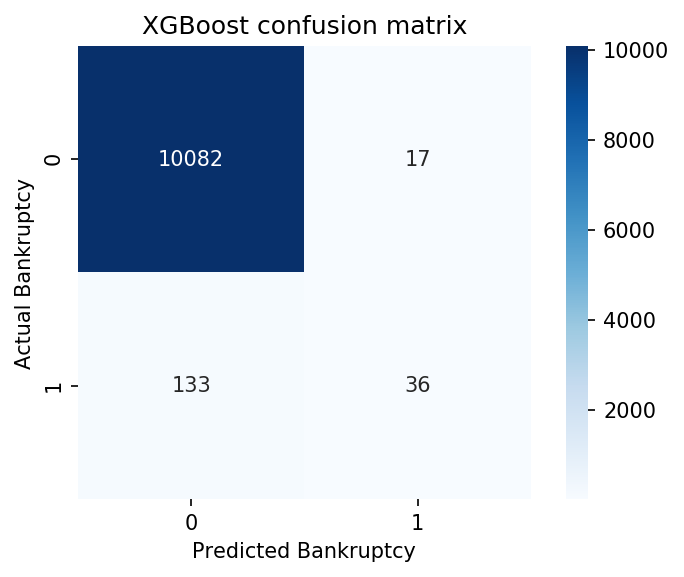

In [304]:
# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, RF_m.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Random Forest');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, RF_m.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

### XGB

ROC AUC score =  0.9812949433742049


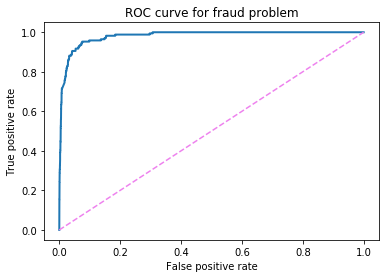

In [305]:
xgb.fit(X_train, y_train)

fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

In [ ]:
from sklearn.ensemble import IsolationForest

# Using Fancy Impute and SMOTE

In [25]:
X = X_filled_knn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [20]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=3).fit_transform(X)


# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
#X_filled_nnm = NuclearNormMinimization().fit_transform(X)

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
#X_incomplete_normalized = BiScaler().fit_transform(X)
#X_filled_softimpute = SoftImpute().fit_transform(X)

Imputing row 1/34226 with 15 missing, elapsed time: 901.020
Imputing row 101/34226 with 19 missing, elapsed time: 901.964
Imputing row 201/34226 with 19 missing, elapsed time: 903.667
Imputing row 301/34226 with 40 missing, elapsed time: 904.472
Imputing row 401/34226 with 20 missing, elapsed time: 905.542
Imputing row 501/34226 with 18 missing, elapsed time: 906.297
Imputing row 601/34226 with 23 missing, elapsed time: 907.064
Imputing row 701/34226 with 15 missing, elapsed time: 907.856
Imputing row 801/34226 with 23 missing, elapsed time: 908.647
Imputing row 901/34226 with 20 missing, elapsed time: 909.370
Imputing row 1001/34226 with 56 missing, elapsed time: 910.150
Imputing row 1101/34226 with 31 missing, elapsed time: 910.719
Imputing row 1201/34226 with 25 missing, elapsed time: 911.410
Imputing row 1301/34226 with 21 missing, elapsed time: 912.320
Imputing row 1401/34226 with 20 missing, elapsed time: 913.224
Imputing row 1501/34226 with 21 missing, elapsed time: 914.040
Impu

Imputing row 13001/34226 with 22 missing, elapsed time: 1029.716
Imputing row 13101/34226 with 31 missing, elapsed time: 1030.501
Imputing row 13201/34226 with 23 missing, elapsed time: 1031.467
Imputing row 13301/34226 with 17 missing, elapsed time: 1032.176
Imputing row 13401/34226 with 24 missing, elapsed time: 1033.027
Imputing row 13501/34226 with 26 missing, elapsed time: 1033.884
Imputing row 13601/34226 with 29 missing, elapsed time: 1034.838
Imputing row 13701/34226 with 26 missing, elapsed time: 1035.908
Imputing row 13801/34226 with 32 missing, elapsed time: 1036.869
Imputing row 13901/34226 with 14 missing, elapsed time: 1037.752
Imputing row 14001/34226 with 15 missing, elapsed time: 1038.577
Imputing row 14101/34226 with 27 missing, elapsed time: 1039.301
Imputing row 14201/34226 with 22 missing, elapsed time: 1040.037
Imputing row 14301/34226 with 17 missing, elapsed time: 1040.692
Imputing row 14401/34226 with 21 missing, elapsed time: 1041.223
Imputing row 14501/34226 

Imputing row 25701/34226 with 16 missing, elapsed time: 1160.798
Imputing row 25801/34226 with 24 missing, elapsed time: 1161.685
Imputing row 25901/34226 with 15 missing, elapsed time: 1162.652
Imputing row 26001/34226 with 23 missing, elapsed time: 1163.798
Imputing row 26101/34226 with 20 missing, elapsed time: 1164.704
Imputing row 26201/34226 with 12 missing, elapsed time: 1165.348
Imputing row 26301/34226 with 14 missing, elapsed time: 1166.154
Imputing row 26401/34226 with 17 missing, elapsed time: 1166.950
Imputing row 26501/34226 with 17 missing, elapsed time: 1169.173
Imputing row 26601/34226 with 22 missing, elapsed time: 1171.912
Imputing row 26701/34226 with 22 missing, elapsed time: 1173.873
Imputing row 26801/34226 with 25 missing, elapsed time: 1174.684
Imputing row 26901/34226 with 22 missing, elapsed time: 1175.554
Imputing row 27001/34226 with 35 missing, elapsed time: 1176.958
Imputing row 27101/34226 with 20 missing, elapsed time: 1178.261
Imputing row 27201/34226 

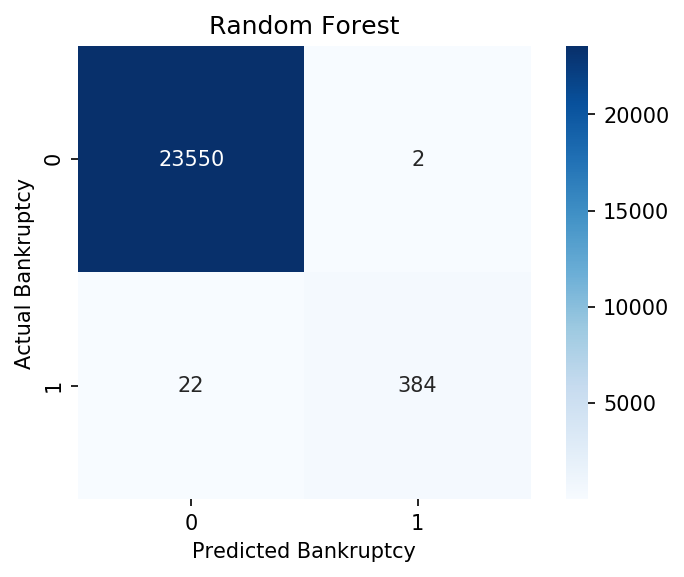

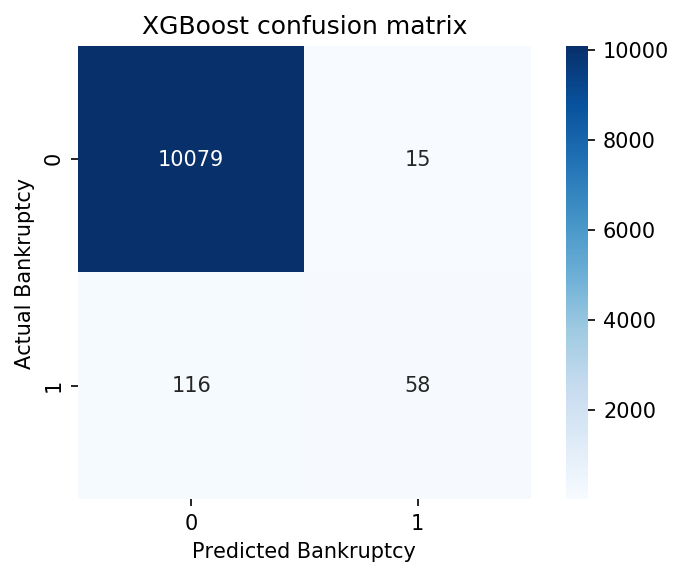

In [26]:
param_dict={'base_score':.5 ,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 3,
 'max_depth': 15,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic'
           }
#**param_dict,n_jobs=2
xgb = xgboost.XGBClassifier()

xgb.fit(X_train, y_train)

# Print confusion matrix for Gaussian
GNB_confusion = confusion_matrix(y_train, xgb.predict(X_train))
plt.figure(dpi=150)
sns.heatmap(GNB_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('Random Forest');

# Print confusion matrix for Gaussian
rf_confusion = confusion_matrix(y_test, xgb.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Bankruptcy')
plt.ylabel('Actual Bankruptcy')
plt.title('XGBoost confusion matrix');

In [28]:
X_filled_knn

array([[1.11690000e+03, 8.92000000e+01, 2.83100000e+02, ...,
        1.61300000e+02, 2.83100000e+02, 5.99400000e+02],
       [9.54100000e+02, 5.47000000e+01, 2.29000000e+02, ...,
        2.00700000e+02, 2.29000000e+02, 3.34950000e+02],
       [8.73100000e+02, 3.12000000e+01, 2.42700000e+02, ...,
        1.53600000e+02, 2.42700000e+02, 2.88150000e+02],
       ...,
       [1.51092000e+05, 8.40711653e+04, 6.46776923e+03, ...,
        7.87491888e+04, 6.46776923e+03, 4.92646500e+05],
       [1.08391000e+05, 5.43883210e+04, 6.46776923e+03, ...,
        1.02959755e+05, 6.46776923e+03, 3.52267500e+05],
       [1.04501000e+05, 1.23304174e+05, 2.93324072e+04, ...,
        7.98554723e+04, 2.93324072e+04, 1.01263400e+06]])